In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-out.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

season = 13
df = df[df['season'] == season]
len(df)

37615

In [2]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]# * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]# * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]# * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2/freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes

def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul

def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        pass
        # if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            # mul += 0.05
    if "GROWTH" in btm:
        # mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
#         pass
        mul += 1.0
    if "SMOOTH" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        mul += 2.0
#         pass
    return mul

def get_fielder_mul(row):
    fm = str(row["defender_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    return mul

In [3]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)

In [4]:
df['baserunner_n'] = [int(np.floor(len(x)/40)) for x in df.loc[:, 'baserunner_count']]

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

for attr in ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']:
    df[attr] = df[attr] * df['batter_mul']
    df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['batter_vibes'])
df = df.copy()
for attr in ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']:
    df[attr] = df[attr] * df['pitcher_mul']
    df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['pitcher_vibes'])

if "defender_vibes" in df:
    for attr in ["defense_avg_anticapitalism", "defense_avg_chasiness", "defense_avg_omniscience", "defense_avg_tenaciousness", "defense_avg_watchfulness"]:
        df[attr] = df[attr] * df['fielder_mul']
        df[attr+'_with_vibe'] = df[attr] * (1 + 0.2 * df['defender_vibes'])

        
df['omni_tenac'] = df['defense_avg_omniscience_with_vibe'] * df['defense_avg_tenaciousness_with_vibe']


df['roll_minus_knowns'] = df['roll'] - 0.1 * df['batter_thwackability_with_vibe'] + 0.08 * df['pitcher_unthwackability_with_vibe']

df['cold_runners'] = df['pitcher_coldness_with_vibe'] * (1 + df['baserunner_n'])
df['omnisq'] = df['defense_avg_omniscience_with_vibe'] * df['defense_avg_omniscience_with_vibe']
df['rollsq'] = df['roll'] * df['roll']
df = df.copy()

In [5]:
dfc = df.copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
for exclude_mod in ["SPICY", "ON_FIRE"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]


dfc = dfc[(dfc['pitcher_mul'] == 1) & (dfc['batter_mul'] == 1)]

# dfc = dfc[dfc['stadium_id'].isna()]

len(dfc)

29346

In [185]:
# X = dfc[['roll_minus_knowns', 'passed',
X = dfc[['roll', 'passed',
         'batter_thwackability_with_vibe',
         'pitcher_unthwackability_with_vibe',
         # 'pitcher_coldness_with_vibe',
         'defense_avg_omniscience_with_vibe',
         # 'omnisq',
         # 'baserunner_n',
         # 'cold_runners',
         # 'defense_avg_tenaciousness_with_vibe',
         # 'defense_avg_watchfulness_with_vibe',
         # 'defense_avg_anticapitalism_with_vibe',
         # 'defense_avg_chasiness_with_vibe',
         # 'fielder_roll',
         # 'omni_tenac',
         'ballpark_grandiosity',
         # 'ballpark_fortification',
         'ballpark_obtuseness',
         # 'ballpark_ominousness',
         'ballpark_inconvenience',
         'ballpark_viscosity',
         'ballpark_forwardness',
         # 'ballpark_elongation',
         # 'ballpark_mysticism',
         'ballpark_filthiness',
         ]]
# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X['passed']
X = X.drop('passed', axis=1)

In [186]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y,predictionsvm))
print(classification_report(y,predictionsvm))
print(trainedsvm.score(X2, y))

[[20932     4]
 [    4  8406]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20936
        True       1.00      1.00      1.00      8410

    accuracy                           1.00     29346
   macro avg       1.00      1.00      1.00     29346
weighted avg       1.00      1.00      1.00     29346

0.9997273904450351


In [187]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.30005905]


[(1.0, 'roll'),
 (-0.10050823510489429, 'batter_thwackability_with_vibe'),
 (0.0796707758031995, 'pitcher_unthwackability_with_vibe'),
 (0.06435167801390816, 'defense_avg_omniscience_with_vibe'),
 (-0.009776483416523868, 'ballpark_forwardness'),
 (-0.009118249408313014, 'ballpark_grandiosity'),
 (-0.009112481509532798, 'ballpark_obtuseness'),
 (0.006578018188654503, 'ballpark_filthiness'),
 (0.0032259616992003676, 'ballpark_inconvenience'),
 (0.0026685508124676244, 'ballpark_viscosity')]

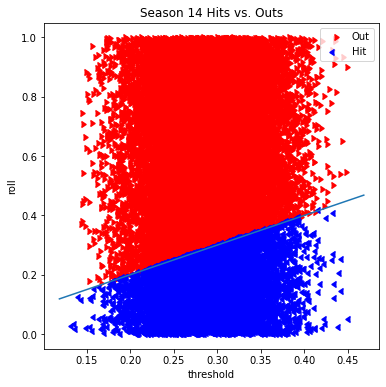

In [176]:
dfc['threshold'] = (0.315 - (
 -0.10 * dfc['batter_thwackability_with_vibe']
 +0.08 * dfc['pitcher_unthwackability_with_vibe']
 +0.07 * dfc['defense_avg_omniscience_with_vibe']
))

dfc['threshold'] = (0.300 - (
    - 0.10 * dfc['batter_thwackability_with_vibe']
    + 0.08 * dfc['pitcher_unthwackability_with_vibe']
    + 0.065 * dfc['defense_avg_omniscience_with_vibe']
    - 0.01 * dfc['ballpark_forwardness']
    - 0.01 * dfc['ballpark_grandiosity']
    - 0.01 * dfc['ballpark_obtuseness']
    + 0.003* dfc['ballpark_viscosity']
    + 0.003* dfc['ballpark_inconvenience']
    # + 0.007* dfc['ballpark_filthiness']
))

# dfc['threshold'] = -intercept_scaled[0]
# print(-intercept_scaled)
# for pair in zip(-np.array(coef_list), X.columns):
#     if pair[1] != "roll":
#         print(pair)
#         dfc['threshold'] += pair[0] * dfc[pair[1]]
        
# dfc['threshold'] -= - 0.1 * df['batter_thwackability_with_vibe'] + 0.08 * df['pitcher_unthwackability_with_vibe']
    
y_val = "roll"
x_val = "threshold"
# x_val = "fielder_roll"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']][y_val], color="red",
           label="Out", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']][y_val], color="blue",
           label="Hit", marker=CARETLEFTBASE)
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title(f"Season {season+1} Hits vs. Outs")
# ax.set_xlim(0.484, 0.499)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

15


,offset,event_type,pitcher_mul,batter_mul,fielder_mul,event_type,roll,threshold,batter_thwackability_with_vibe,pitcher_unthwackability_with_vibe,defense_avg_omniscience_with_vibe,batter_name,pitcher_name,fielder_name,batter_mods,pitcher_mods,defender_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count,fielder_roll,ballpark_ominousness
33325,0.001124,BaseHit,1.0,1.0,1.0,BaseHit,0.326461,0.325337,1.283122,1.000996,0.610682,Francisca Sasquatch,Jordan Hildebert,Comfo-t S-p---be-ish,HONEY_ROASTED,FRIEND_OF_CROWS;SIPHON,SCATTERED,LIFE_OF_PARTY;ELECTRIC,NaN,29,c87d2155-a791-47dc-830a-0e06ff2097be,319,0.131666,0.471649
39903,-0.000011,Flyout,1.0,1.0,1.0,Flyout,0.267952,0.267964,0.571435,1.230411,0.082065,Ni- Winkler,Agan Harrison,Justice Spoon,SCATTERED,NaN,ALTERNATE;FIRE_EATER,GROWTH,NaN,40,e28943d4-092b-4892-bf82-edb94e31081c,188,0.532930,0.491609
34109,-0.000013,GroundOut,1.0,1.0,1.0,GroundOut,0.342275,0.342288,0.972270,0.198048,0.859910,Yrjö Kerfuffle,NaN,Kaz Fiasco,NaN,FLICKERING;RECEIVER,NaN,NaN,BOTTOM_DWELLER,31,1aad07e1-7f2b-4493-96c7-7b858a6b819b,92,0.764993,0.471649
68164,-0.000059,GroundOut,1.0,1.0,1.0,GroundOut,0.213357,0.213415,0.179301,1.024183,0.553167,Stijn Strongbody,Wesley Poole,Socks Maybe,SWIM_BLADDER,NaN,NaN,NaN,NaN,91,25812b54-0175-4a21-9adf-f523bce87cf6,289,0.455194,0.469844
44439,-0.000100,GroundOut,1.0,1.0,1.0,GroundOut,0.309996,0.310096,0.923292,0.754476,0.542323,Steph Weeks,Caleb Alvarado,Socks Maybe,FIRE_EATER,FRIEND_OF_CROWS,NaN,EARLBIRDS,NaN,47,9dede6c6-5aea-41cf-8462-9717c124719b,236,0.463253,0.469844
65506,-0.000137,GroundOut,1.0,1.0,1.0,GroundOut,0.282499,0.282636,0.817918,1.077440,0.456601,Velasquez Alstott,Inky Rutledge,Bonk Jokes,FLINCH;FIRE_EATER,NaN,NaN,TRAVELING;PARTY_TIME,O_NO,87,6cca6460-266a-4e2c-8a6b-0c0cc1097f5f,159,0.549246,0.498974
84085,-0.000246,GroundOut,1.0,1.0,1.0,GroundOut,0.274786,0.275031,0.467531,1.009648,0.117977,Huber Frumple,Inky Rutledge,Eizabeth Elliott,NaN,NaN,NaN,AFFINITY_FOR_CROWS,O_NO,104,bf090bfc-0b4b-4654-bd85-f2ec3123341d,50,0.957672,0.498974
73681,-0.000264,GroundOut,1.0,1.0,1.0,GroundOut,0.323189,0.323453,1.207072,0.766287,0.721207,Knight Triumphant,Tot Clark,Malik Destiny,SIPHON;PERK,NaN,ALTERNATE;FIRE_EATER,LOVE,NaN,9,68bf182a-53c4-4f41-8b4c-28b2e0326125,19,0.343765,0.495296
35201,-0.000359,GroundOut,1.0,1.0,1.0,GroundOut,0.336068,0.336427,0.766098,0.625702,0.105310,Kurt Crueller,Ruslan Greatness,Beasley Day,NaN,FRIEND_OF_CROWS,NaN,O_NO,AFFINITY_FOR_CROWS,33,ec2eb4d3-b81a-430d-90c0-328371126cb2,24,0.193326,0.498974
82213,-0.000415,GroundOut,1.0,1.0,1.0,GroundOut,0.269915,0.270329,0.463527,1.009648,0.142414,Summers Pony,Inky Rutledge,Eizabeth Elliott,NaN,TRIPLE_THREAT,NaN,NaN,O_NO,22,76795bae-2e33-4e19-9082-0b3bf6965b6b,310,0.999097,0.696044


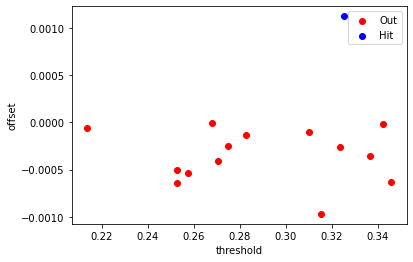

In [177]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
# x_val = "defense_avg_omniscience_with_vibe"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="Out")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Hit")
ax.set_xlabel(x_val)
ax.set_ylabel('offset')
ax.legend()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
table = outliers[["offset", "event_type", #"home_score", "away_score", "top_of_inning", "inning",
       "pitcher_mul", "batter_mul", "fielder_mul",# "baserunner_count",
       "event_type", "roll", "threshold",# "batter_vibes", "pitcher_vibes",
       "batter_thwackability_with_vibe", "pitcher_unthwackability_with_vibe", "defense_avg_omniscience_with_vibe",
       "batter_name", "pitcher_name", "fielder_name", "batter_mods", "pitcher_mods", "defender_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count",
       "fielder_roll", "ballpark_ominousness"]]
print(len(table))
table.sort_values('offset', ascending=False)[0:10]


In [153]:
# outliers.sort_values('roll', ascending=True).style.hide()
dfc.groupby('fielder_name').size().sort_values(ascending=False)[0:15]

fielder_name
Halexandrey Walton    327
Basilio Fig           297
Basilio Mason         276
Valentine Games       269
Yusef Puddles         253
Eduardo Woodman       232
Jode Preston          222
Nicholas Mora         212
Hercules Alighieri    207
Paula Mason           200
Niq Nyong'o           200
Randy Castillo        200
Kennedy Loser         199
Muse Scantron         198
Huber Frumple         196
dtype: int64

In [133]:
dfc.corr()['offset'].sort_values()[0:10]

passed                           -0.780355
threshold                        -0.153008
batter_thwackability_with_vibe   -0.112903
batter_thwackability             -0.107949
batter_musclitude_with_vibe      -0.042431
batter_musclitude                -0.037351
batter_overpowerment_with_vibe   -0.034344
batter_vibes                     -0.032145
batter_overpowerment             -0.029875
batter_vibes_multiplied          -0.028478
Name: offset, dtype: float64

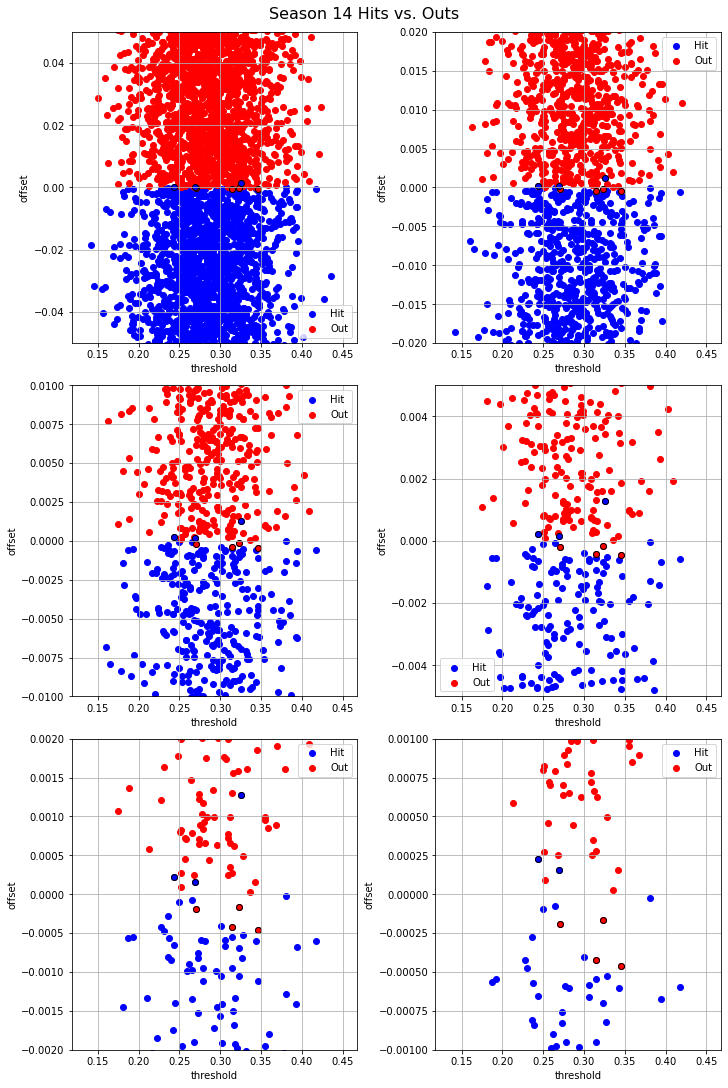

In [159]:
plt.rcParams["font.size"] = 10
x_val = 'threshold'
fig, axes = plt.subplots(3,2, figsize=(10,15), constrained_layout=True)
fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, .5e-2, .2e-2, .1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]['offset'], color="blue", label="Hit")
    ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]['offset'], color="red", label="Out")
    ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", edgecolor="black")
    ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", edgecolor="black")
    ax.set_xlabel(x_val)
    ax.set_ylabel('offset')
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("hit_out_fit_offsets.png", facecolor='white')


In [14]:
dfc.groupby('baserunner_count').size().sort_values(ascending=False)[0:15]

baserunner_count
[]                                          19776
['03b80a57-77ea-4913-9be4-7a85c3594745']       98
['efafe75e-2f00-4418-914c-9b6675d39264']       84
['c675fcdf-6117-49a6-ac32-99a89a3a88aa']       82
['c755efce-d04d-4e00-b5c1-d801070d3808']       81
['17392be2-7344-48a0-b4db-8a040a7fb532']       72
['2ffbaec8-a646-4435-a17a-3a0a2b5f3e16']       70
['27c68d7f-5e40-4afa-8b6f-9df47b79e7dd']       70
['32810dca-825c-4dbc-8b65-0702794c424e']       68
['ac69dba3-6225-4afd-ab4b-23fc78f730fb']       62
['27839754-c351-43ec-9bff-ca662a2385b9']       62
['740d5fef-d59f-4dac-9a75-739ec07f91cf']       62
['9a031b9a-16f8-4165-a468-5d0e28a81151']       60
['88cd6efa-dbf2-4309-aabe-ec1d6f21f98a']       59
['083d09d4-7ed3-4100-b021-8fbe30dd43e8']       58
dtype: int64

In [15]:
max(len(x) for x in dfc.loc[:, 'baserunner_count'])

120

In [16]:
dfc.groupby('stadium_id').size()

stadium_id
031670ae-97a5-4215-b1a1-98e9f1de7c50     937
06c991f6-4ef3-4a9a-8254-8a2bc7d3a1e1    1493
1c1614b3-abdb-4008-98eb-12aeb8f7bb54     896
21ce1233-b2d6-4bd2-8d03-68a8915afdc5    1078
2841dc8c-b5a2-4b3a-a717-9e646e8e29fc    1308
2a1a52b3-9759-44aa-ba49-b1437396d895    1680
36ae955c-6264-4437-8669-3053f62992e5    1637
36b94380-39a6-4e32-b525-3e888215798a    2726
37c2743f-1a15-4e3f-bdb1-a6461df93434    1435
43fbdf41-336f-46a8-9445-eb8a6e05d811    1111
60e78a6c-fe49-4283-8293-735e9fa7e3e9     872
6bfd22e7-831d-4ba9-a9f9-2cf7ab00c39d    1437
7f09624b-b3cf-4493-b768-adf090bebf21    1531
8a84154e-80d7-47d5-8f56-295e9a9653d9    1089
8e900d85-7d4c-47d0-a67f-6432144f0210    1024
929fc650-948a-4736-b7a2-bb7b75902e6e    1019
a0851e18-d5d7-4749-b3c5-c6023fe1cc61    1553
a109bd65-bfd3-43c7-9eb8-70dddc4d8a29    1200
ba794e99-4d6b-4e12-9450-6522745190f8    1203
cb94ac8b-003b-4d95-baf3-7c14b1c3fc29     939
cfb57d7c-4118-4b0a-85cc-4e3a51a66cb6    1197
d37abba6-9fba-463a-8f4f-7cf49de3c7b6     517